In [ ]:
from probatus.feature_elimination import ShapRFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut
from sklearn.model_selection import cross_val_score
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
food_data = pd.read_csv('../data/processed_data/diet.csv')
food_data = food_data[food_data.columns[2:]].drop(['Confirmed', 'Deaths', 'Recovered'],axis=1)
food_data.head()

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Milk - Excluding Butter,Miscellaneous,Offals,Oilcrops,Pulses,Spices,Starchy Roots,Stimulants,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetal Products,Vegetable Oils,Vegetables
0,0.000030,0.209212,0.094048,0.0,0.932183,0.102107,0.000030,0.172718,0.099611,0.307722,0.020510,0.164290,0.014672,0.073098,0.086036,0.004887,0.161764,0.0,0.093136,0.087701,0.839472,0.118219,0.259702
1,0.140102,0.706896,0.102562,0.0,0.190717,0.462279,0.028297,0.341492,0.288519,0.917774,0.040196,0.278848,0.074529,0.085016,0.000402,0.053821,0.100273,0.0,0.148501,0.207074,0.278154,0.128436,0.611097
2,0.019552,0.275546,0.016821,0.0,0.539036,0.311591,0.027459,0.298529,0.104371,0.412494,0.067004,0.079743,0.024465,0.140397,0.092487,0.111608,0.139696,0.0,0.176586,0.151658,0.743623,0.397735,0.595502
3,0.404646,0.206405,0.034244,0.0,0.330536,0.025393,0.228756,0.266748,0.264876,0.043159,0.043857,0.165409,0.133725,0.202901,0.000453,0.582692,0.030827,0.0,0.137324,0.004308,0.753912,0.232472,0.105695
4,0.263935,0.725172,0.111637,0.0,0.120333,0.125973,0.437713,0.402774,0.689613,0.403340,0.227956,0.210045,0.055471,0.053701,0.233798,0.029236,0.173150,0.0,0.318216,0.043437,0.208668,0.372299,0.271631


In [ ]:
country = pd.read_csv('../data/raw_data/control/regression_targets.csv')
targets = country[['Country', 'Deaths', 'Confirmed', 'Active', 'Recovered']]
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Country      0
Deaths       6
Confirmed    6
Active       8
Recovered    6
dtype: int64


,Country,Deaths,Confirmed,Active,Recovered
0,Afghanistan,0.006186,0.142134,0.012574,0.123374
1,Albania,0.050951,2.967301,1.123714,1.792636
2,Algeria,0.006558,0.244897,0.070767,0.167572
3,Angola,0.001461,0.061687,0.003419,0.056808
4,Antigua and Barbuda,0.007143,0.293878,0.095918,0.190816


In [ ]:
targets.dropna(axis=0, inplace=True)

In [ ]:
food_data = food_data.merge(targets, on='Country', how='inner')

In [ ]:
label_values = ['Deaths', 'Active', 'Recovered', 'Confirmed']
features_food = food_data.columns.drop(label_values)
features_food = features_food.drop(['Country'])
X_food = food_data[features_food]
Y_food = food_data[label_values]

In [ ]:
PARAMS = {
    'max_depth': [2, 3, 5, 7, 10],
    'min_child_weight': [3, 4, 5, 6],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 75, 100, 150, 200, 250, 300, 350]
}

In [ ]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=LeaveOneOut())
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [ ]:
def rfecv_shap_algorithm(estimator, X, Y, algorithm, step=1, score='neg_median_absolute_error'):
  shap_elimination = ShapRFECV(clf=estimator, step=step, cv=5, scoring=score, n_jobs=3)
  shap_report = shap_elimination.fit_compute(X, Y)
  best_features_rfe_shap = shap_report[shap_report['val_metric_mean'] == shap_report['val_metric_mean'].max()]
  features_shap = list(best_features_rfe_shap['features_set'].values[0])
  features_shap_cv = {}
  features_shap_cv['algorithm'] = 'rfe - measure shap ' + algorithm
  features_shap_cv['selected_features'] = features_shap
  features_shap_cv['number_of_features'] = len(features_shap)
  features_shap_cv['neg_mae_score_cv'] = shap_report['val_metric_mean'].max()
  feat_shap = pd.DataFrame(features_shap_cv)
  feat_shap.to_csv('../data/feature_selection/selected_features_rfe_shap_' + algorithm + '.csv', index=False)
  return feat_shap

In [ ]:
xgboost_best_food_params, xgboost_best_food_score = hyper_parameter_search(X_food, Y_food['Deaths'], PARAMS)

[19:25:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(f'best parameters: {xgboost_best_food_params}')
print(f'score: {xgboost_best_food_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 150}
score: -0.027112979726802804


In [ ]:
xgb_food = XGBRegressor(gamma = xgboost_best_food_params['gamma'], 
                        learning_rate = xgboost_best_food_params['learning_rate'],
                        max_depth = xgboost_best_food_params['max_depth'],
                        min_child_weight = xgboost_best_food_params['min_child_weight'],
                        n_estimators = xgboost_best_food_params['n_estimators'],
                        random_state=0)

In [ ]:
rfecv_xgb_food = rfecv_shap_algorithm(xgb_food, X_food, Y_food['Deaths'], 'food')

In [ ]:
rfecv_xgb_food

,algorithm,selected_features,number_of_features,neg_mae_score_cv
0,rfe - measure shap food,"Fish, Seafood",4,-0.014
1,rfe - measure shap food,Alcoholic Beverages,4,-0.014
2,rfe - measure shap food,Eggs,4,-0.014
3,rfe - measure shap food,Milk - Excluding Butter,4,-0.014


In [ ]:
selected_features_food = rfecv_xgb_food['selected_features'].values

<h3>Shap feature importnace</h3>

In [ ]:
X_train_food, X_test_food, Y_train_food, Y_test_food = train_test_split(
    X_food[selected_features_food],
    Y_food,
    test_size = 0.2
)

In [ ]:
xgb_food.fit(X_train_food, Y_train_food['Deaths'])

[22:49:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=5, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

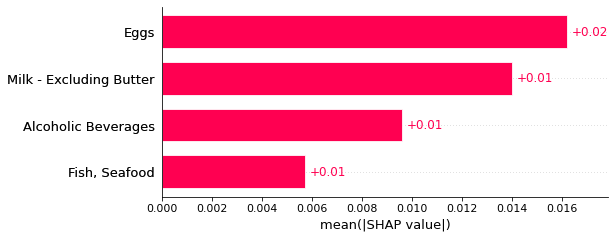

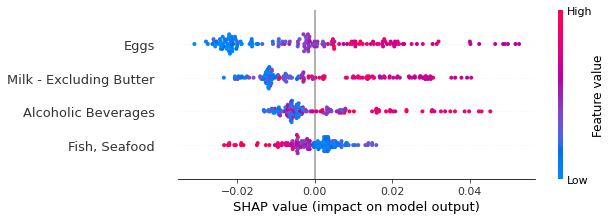

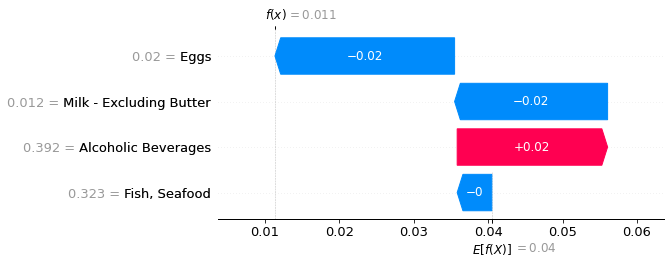

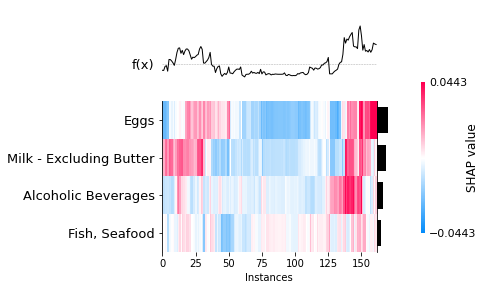

In [ ]:
expl = shap.Explainer(xgb_food, X_food[selected_features_food])
shap_values = expl(X_food[selected_features_food])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)
shap.plots.waterfall(shap_values[30])
shap.plots.heatmap(shap_values)